In [1]:
import numpy as np

Encoderのhsと重み(hsとDecoderのhにおける内積)の積和を求めて必要な隠れ状態を抽出

In [2]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')

class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a): # Encoderの全ての隠れ状態、重み(hsと各時刻のhにおける内積)
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)#.repeat(T, axis=1)
        t = hs * ar # hsのそれぞれの隠れ状態に重みをかける
        c = np.sum(t, axis=1) # コンテキストベクトル（hsから現時刻の単語に関連するベクトルを抽出）

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da


WeightSumの重み：Encoder内全ての隠れ状態hsとDecoderの各時刻(入力)における隠れ状態の内積（＝入力と）

In [3]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1) # hs分だけのhを複製
        # Encoderの全隠れ状態hsにおける各要素と現時刻の隠れ状態の内積
        t = hs * hr
        s = np.sum(t, axis=2)
        # 内積を正規化(0から1)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a # 現時刻の単語に対する関連度に合わせた重み（この重みを使ってhsから必要なベクトルを抽出）

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

Attention（AttentionWeightとWeightSumをまとめる）実装

In [4]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h) # 現地獄の単語に関連した重みを求める
        out = self.weight_sum_layer.forward(hs, a) # 重みを使ってhsから関連した隠れベクトルを抽出
        self.attention_weight = a # 後で参照する
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

TimeAttention（時系列方向に広がった複数のAttentionをまとめた）実装

In [5]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            # 各時刻の単語に関連した隠れベクトルをhs_encから抽出
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out # Affineレイヤに渡される

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

改良版Encoderの実装（最後の隠れ状態だけでなく全ての隠れ状態をまとめて返す）

In [6]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from ch07.seq2seq import Encoder

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs # 前章ではhs[:, -1, :]

    def backward(self, dhs):
        # 前章ではdhs[:, -1, :] = dhで最終時刻の隠れ状態を逆伝播した
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

AttentionDecoder(Attentionを搭載した改良版Decoder)を実装

In [7]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.time_layers import *

class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention() # 追加点
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1] # 今まで通りEncoderからの最後の隠れ状態も最初のLSTMに渡す
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        # Attentionレイヤでコンテキストベクトル（Encoder全情報のうち現時刻の隠れ状態に関連した情報）
        c = self.attention.forward(enc_hs, dec_hs)
        # コンテキストベクトルと下のLSTMから出力された隠れ状態を結合
        out = np.concatenate((c, dec_hs), axis=2) # Hが二倍の長さになる
        score = self.affine.forward(out) # Encoderの関連した隠れベクトルとDecoderで出力した隠れベクトルを合わしたうえでスコア計算
        # Attentionがなかった前回は、Encoderの情報が固定長ベクトルのため情報が溢れてスコア計算に加味されづらかった

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape # 前伝播で同じ種のベクトル（c, dec_hs）を結合したからHの大きさが2倍
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh # 最終時刻の隠れ状態の勾配(Encoderに渡す)
        denc_hs[:, -1] += dh # 前伝播時に全隠れ状態と最終列を渡したから、ここでまとめて逆伝播
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size): # 前回はEncoderの最後の隠れ状態hを受け取ったが今回は全隠れ状態を受け取る
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1] # ここでEncoderの最終時刻における隠れ状態hを取得
        self.lstm.set_state(h) #DecoderのLSTMに渡す

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

Attentionが追加された改良版seq2seqの実装

In [8]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from ch07.seq2seq import Seq2seq

class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads


AttentionSeq2seqの学習とテスト（他のモデルとの比較）

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 4[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 9[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 13[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 18[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 23[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 28[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 33[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 38[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 43[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 48[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 54[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 59[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 64[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 69[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 74[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 79[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 84[s] | loss 1.00
Q 10/15/94                     
T 1994-10-15
X 1978-08-

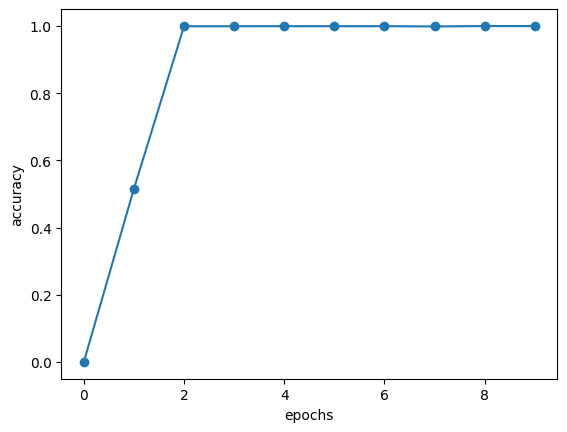

In [2]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))


model.save_params()

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()



===== Seq2seq Epoch 1/10 =====
| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 2[s] | loss 3.34
| epoch 1 |  iter 41 / 351 | time 5[s] | loss 1.96
| epoch 1 |  iter 61 / 351 | time 7[s] | loss 1.79
| epoch 1 |  iter 81 / 351 | time 10[s] | loss 1.70
| epoch 1 |  iter 101 / 351 | time 12[s] | loss 1.54
| epoch 1 |  iter 121 / 351 | time 15[s] | loss 1.27
| epoch 1 |  iter 141 / 351 | time 18[s] | loss 1.17
| epoch 1 |  iter 161 / 351 | time 20[s] | loss 1.12
| epoch 1 |  iter 181 / 351 | time 23[s] | loss 1.08
| epoch 1 |  iter 201 / 351 | time 26[s] | loss 1.06
| epoch 1 |  iter 221 / 351 | time 28[s] | loss 1.05
| epoch 1 |  iter 241 / 351 | time 31[s] | loss 1.04
| epoch 1 |  iter 261 / 351 | time 33[s] | loss 1.04
| epoch 1 |  iter 281 / 351 | time 36[s] | loss 1.03
| epoch 1 |  iter 301 / 351 | time 38[s] | loss 1.03
| epoch 1 |  iter 321 / 351 | time 41[s] | loss 1.03
| epoch 1 |  iter 341 / 351 | time 44[s] | loss 1.02
Q 10/15/94              

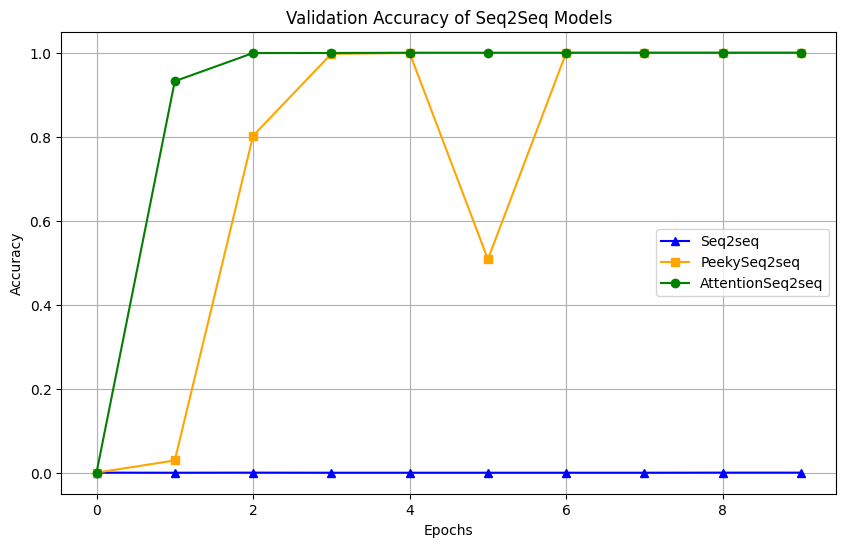

In [17]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

# 各モデルの定義
models = [
    Seq2seq(vocab_size, wordvec_size, hidden_size),
    PeekySeq2seq(vocab_size, wordvec_size, hidden_size),
    AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
]

# モデルごとに学習と精度計算を行う
acc_lists = []

# グラフの描画用の設定
markers = ['^', 's', 'o']
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    optimizer = Adam()
    trainer = Trainer(model, optimizer)

    acc_list = []
    for epoch in range(max_epoch):
        print(f'\n===== {model.__class__.__name__} Epoch {epoch+1}/{max_epoch} =====')
        trainer.fit(x_train, t_train, max_epoch=1,
                    batch_size=batch_size, max_grad=max_grad)

        correct_num = 0
        for j in range(len(x_test)):
            question, correct = x_test[[j]], t_test[[j]]
            verbose = j < 10
            correct_num += eval_seq2seq(model, question, correct,
                                        id_to_char, verbose, is_reverse=True)

        acc = float(correct_num) / len(x_test)
        acc_list.append(acc)
        print(f'Model: {model.__class__.__name__}, Epoch: {epoch+1}/{max_epoch}, Validation Accuracy: {acc * 100:.3f}%')

    acc_lists.append(acc_list)

    # グラフ描画
    plt.plot(np.arange(max_epoch), acc_list, marker=markers[i], color=colors[i], label=model.__class__.__name__)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy of Seq2Seq Models')
plt.legend()
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()



| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 3[s] | loss 2.86
| epoch 1 |  iter 41 / 351 | time 6[s] | loss 1.89
| epoch 1 |  iter 61 / 351 | time 9[s] | loss 1.78
| epoch 1 |  iter 81 / 351 | time 12[s] | loss 1.70
| epoch 1 |  iter 101 / 351 | time 15[s] | loss 1.57
| epoch 1 |  iter 121 / 351 | time 18[s] | loss 1.30
| epoch 1 |  iter 141 / 351 | time 21[s] | loss 1.16
| epoch 1 |  iter 161 / 351 | time 24[s] | loss 1.10
| epoch 1 |  iter 181 / 351 | time 27[s] | loss 1.07
| epoch 1 |  iter 201 / 351 | time 30[s] | loss 1.05
| epoch 1 |  iter 221 / 351 | time 33[s] | loss 1.04
| epoch 1 |  iter 241 / 351 | time 36[s] | loss 1.04
| epoch 1 |  iter 261 / 351 | time 39[s] | loss 1.03
| epoch 1 |  iter 281 / 351 | time 42[s] | loss 1.02
| epoch 1 |  iter 301 / 351 | time 45[s] | loss 1.01
| epoch 1 |  iter 321 / 351 | time 48[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 51[s] | loss 1.00
Q 10/15/94                     
T 1994-10-15
X 1971-11-1

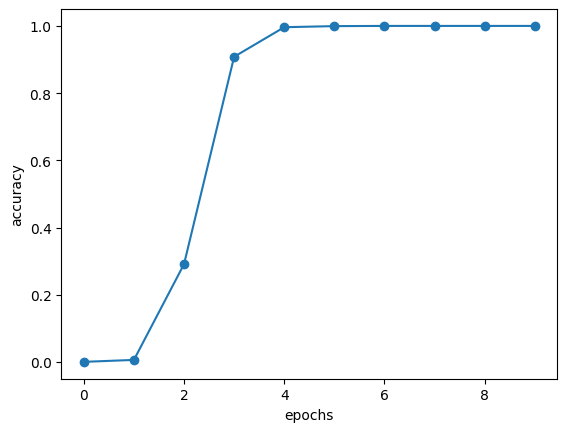

In [2]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data("date.txt")
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

# model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print("val acc %.3f%%" % (acc * 100))


model.save_params()

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker="o")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(-0.05, 1.05)
plt.show()



===== Seq2seq Epoch 1/10 =====
| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 2[s] | loss 3.34
| epoch 1 |  iter 41 / 351 | time 5[s] | loss 1.95
| epoch 1 |  iter 61 / 351 | time 8[s] | loss 1.78
| epoch 1 |  iter 81 / 351 | time 11[s] | loss 1.70
| epoch 1 |  iter 101 / 351 | time 14[s] | loss 1.55
| epoch 1 |  iter 121 / 351 | time 16[s] | loss 1.27
| epoch 1 |  iter 141 / 351 | time 19[s] | loss 1.16
| epoch 1 |  iter 161 / 351 | time 22[s] | loss 1.12
| epoch 1 |  iter 181 / 351 | time 25[s] | loss 1.08
| epoch 1 |  iter 201 / 351 | time 28[s] | loss 1.06
| epoch 1 |  iter 221 / 351 | time 31[s] | loss 1.05
| epoch 1 |  iter 241 / 351 | time 34[s] | loss 1.04
| epoch 1 |  iter 261 / 351 | time 37[s] | loss 1.04
| epoch 1 |  iter 281 / 351 | time 39[s] | loss 1.03
| epoch 1 |  iter 301 / 351 | time 42[s] | loss 1.03
| epoch 1 |  iter 321 / 351 | time 45[s] | loss 1.03
| epoch 1 |  iter 341 / 351 | time 48[s] | loss 1.02
Q 10/15/94              

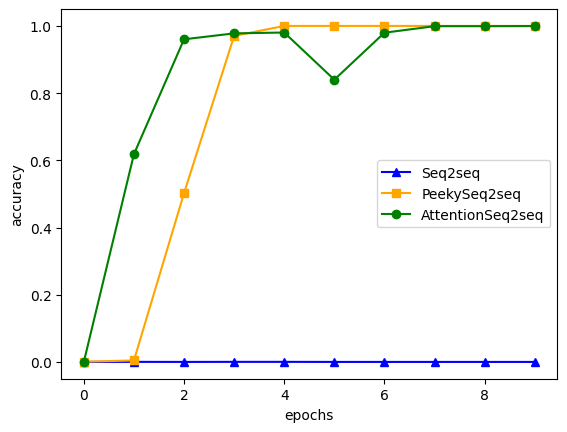

In [1]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
import matplotlib.pyplot as plt
import numpy as np
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq
from ch08.attention_seq2seq import AttentionSeq2seq

# モデルをトレーニングして評価する関数
def train_and_evaluate(model, x_train, t_train, x_test, t_test, max_epoch, batch_size, max_grad, id_to_char):
    optimizer = Adam()
    trainer = Trainer(model, optimizer)
    acc_list = []

    for epoch in range(max_epoch):
        print(f'\n===== {model.__class__.__name__} Epoch {epoch+1}/{max_epoch} =====')
        trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

        correct_num = 0
        for i in range(len(x_test)):
            question, correct = x_test[[i]], t_test[[i]]
            verbose = i < 10
            correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)

        acc = float(correct_num) / len(x_test)
        acc_list.append(acc)
        print(f'Model: {model.__class__.__name__}, Epoch: {epoch+1}/{max_epoch}, Validation Accuracy: {acc * 100:.3f}%')

    model.save_params()
    return acc_list

# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

# Seq2seqモデルのトレーニングと評価
model_seq2seq = Seq2seq(vocab_size, wordvec_size, hidden_size)
acc_seq2seq = train_and_evaluate(model_seq2seq, x_train, t_train, x_test, t_test, max_epoch, batch_size, max_grad, id_to_char)

# PeekySeq2seqモデルのトレーニングと評価
model_peeky = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
acc_peeky = train_and_evaluate(model_peeky, x_train, t_train, x_test, t_test, max_epoch, batch_size, max_grad, id_to_char)

# AttentionSeq2seqモデルのトレーニングと評価
model_attention = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
acc_attention = train_and_evaluate(model_attention, x_train, t_train, x_test, t_test, max_epoch, batch_size, max_grad, id_to_char)

# ３つのモデルの精度を一つのグラフにプロット
epochs = np.arange(max_epoch)
plt.plot(epochs, acc_seq2seq, marker='^', color='blue', label='Seq2seq')
plt.plot(epochs, acc_peeky, marker='s', color='orange', label='PeekySeq2seq')
plt.plot(epochs, acc_attention, marker='o', color='green', label='AttentionSeq2seq')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()


In [1]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

def learn_eval(model):
    # データの読み込み
    (x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
    char_to_id, id_to_char = sequence.get_vocab()

    # 入力文を反転
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

    # ハイパーパラメータの設定
    batch_size = 128
    max_epoch = 10
    max_grad = 5.0

    model = model

    optimizer = Adam()
    trainer = Trainer(model, optimizer)

    acc_list = []
    for epoch in range(max_epoch):
        print(f'\n===== {model.__class__.__name__} Epoch {epoch+1}/{max_epoch} =====')
        trainer.fit(x_train, t_train, max_epoch=1,
                    batch_size=batch_size, max_grad=max_grad)

        correct_num = 0
        for i in range(len(x_test)):
            question, correct = x_test[[i]], t_test[[i]]
            verbose = i < 10
            correct_num += eval_seq2seq(model, question, correct,
                                        id_to_char, verbose, is_reverse=True)

        acc = float(correct_num) / len(x_test)
        acc_list.append(acc)
        print(f'Model: {model.__class__.__name__}, Epoch: {epoch+1}/{max_epoch}, Validation Accuracy: {acc * 100:.3f}%')


    model.save_params()

    return acc_list

In [2]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

Seq2seq = Seq2seq(vocab_size, wordvec_size, hidden_size)
PeekySeq2seq = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
AttentionSeq2seq = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)

acc_seq2seq = learn_eval(Seq2seq)
acc_peeky = learn_eval(PeekySeq2seq)
acc_attention = learn_eval(AttentionSeq2seq)

# ３つのモデルの精度を一つのグラフにプロット
epochs = np.arange(len(acc_seq2seq))
plt.plot(epochs, acc_seq2seq, marker='^', color='blue', label='Seq2seq')
plt.plot(epochs, acc_peeky, marker='s', color='orange', label='PeekySeq2seq')
plt.plot(epochs, acc_attention, marker='o', color='green', label='AttentionSeq2seq')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()


===== Seq2seq Epoch 1/10 =====
| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 3[s] | loss 3.34
| epoch 1 |  iter 41 / 351 | time 5[s] | loss 1.96
| epoch 1 |  iter 61 / 351 | time 8[s] | loss 1.79
| epoch 1 |  iter 81 / 351 | time 11[s] | loss 1.70
| epoch 1 |  iter 101 / 351 | time 14[s] | loss 1.55
| epoch 1 |  iter 121 / 351 | time 17[s] | loss 1.29
| epoch 1 |  iter 141 / 351 | time 20[s] | loss 1.17
| epoch 1 |  iter 161 / 351 | time 23[s] | loss 1.12
| epoch 1 |  iter 181 / 351 | time 25[s] | loss 1.08
| epoch 1 |  iter 201 / 351 | time 28[s] | loss 1.06
| epoch 1 |  iter 221 / 351 | time 31[s] | loss 1.05
| epoch 1 |  iter 241 / 351 | time 34[s] | loss 1.04
| epoch 1 |  iter 261 / 351 | time 37[s] | loss 1.04
| epoch 1 |  iter 281 / 351 | time 40[s] | loss 1.03
| epoch 1 |  iter 301 / 351 | time 43[s] | loss 1.03
| epoch 1 |  iter 321 / 351 | time 46[s] | loss 1.03
| epoch 1 |  iter 341 / 351 | time 49[s] | loss 1.02
Q 10/15/94              

NameError: name 'max_epoch' is not defined

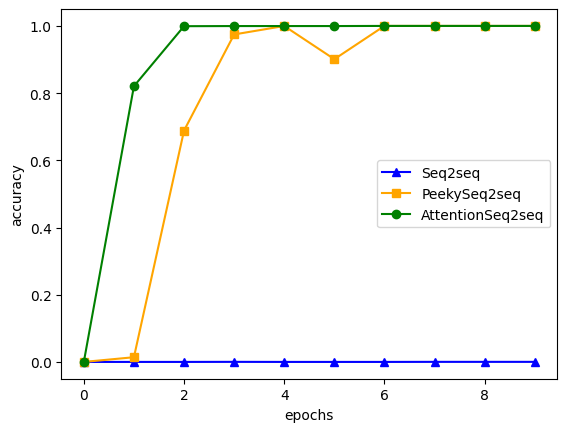

In [3]:
# ３つのモデルの精度を一つのグラフにプロット
epochs = np.arange(len(acc_seq2seq))
plt.plot(epochs, acc_seq2seq, marker='^', color='blue', label='Seq2seq')
plt.plot(epochs, acc_peeky, marker='s', color='orange', label='PeekySeq2seq')
plt.plot(epochs, acc_attention, marker='o', color='green', label='AttentionSeq2seq')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()

In [1]:
# coding: utf-8
import sys

sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

def train_peekySeq2seq():

    # データの読み込み
    (x_train, t_train), (x_test, t_test) = sequence.load_data("date.txt")
    char_to_id, id_to_char = sequence.get_vocab()

    # 入力文を反転
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

    # ハイパーパラメータの設定
    vocab_size = len(char_to_id)
    wordvec_size = 16
    hidden_size = 256
    batch_size = 128
    max_epoch = 10
    max_grad = 5.0

    # model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
    # model = Seq2seq(vocab_size, wordvec_size, hidden_size)
    model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

    optimizer = Adam()
    trainer = Trainer(model, optimizer)

    acc_list = []
    for epoch in range(max_epoch):
        print(f'\n===== {model.__class__.__name__} Epoch {epoch+1}/{max_epoch} =====')
        trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

        correct_num = 0
        for i in range(len(x_test)):
            question, correct = x_test[[i]], t_test[[i]]
            verbose = i < 10
            correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)

        acc = float(correct_num) / len(x_test)
        acc_list.append(acc)
        print(f'Model: {model.__class__.__name__}, Epoch: {epoch+1}/{max_epoch}, Validation Accuracy: {acc * 100:.3f}%')


    model.save_params()

    # グラフの描画
    x = np.arange(len(acc_list))
    plt.plot(x, acc_list, marker="o")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(-0.05, 1.05)
    plt.show()

    return acc_list


In [2]:
# coding: utf-8
import sys

sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

def train_Seq2seq():

    # データの読み込み
    (x_train, t_train), (x_test, t_test) = sequence.load_data("date.txt")
    char_to_id, id_to_char = sequence.get_vocab()

    # 入力文を反転
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

    # ハイパーパラメータの設定
    vocab_size = len(char_to_id)
    wordvec_size = 16
    hidden_size = 256
    batch_size = 128
    max_epoch = 10
    max_grad = 5.0

    # model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
    model = Seq2seq(vocab_size, wordvec_size, hidden_size)
    # model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

    optimizer = Adam()
    trainer = Trainer(model, optimizer)

    acc_list = []
    for epoch in range(max_epoch):
        print(f'\n===== {model.__class__.__name__} Epoch {epoch+1}/{max_epoch} =====')
        trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

        correct_num = 0
        for i in range(len(x_test)):
            question, correct = x_test[[i]], t_test[[i]]
            verbose = i < 10
            correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)

        acc = float(correct_num) / len(x_test)
        acc_list.append(acc)
        print(f'Model: {model.__class__.__name__}, Epoch: {epoch+1}/{max_epoch}, Validation Accuracy: {acc * 100:.3f}%')

    model.save_params()

    # グラフの描画
    x = np.arange(len(acc_list))
    plt.plot(x, acc_list, marker="o")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(-0.05, 1.05)
    plt.show()

    return acc_list


In [3]:
# coding: utf-8
import sys

sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

def train_AttentionSeq2seq():

    # データの読み込み
    (x_train, t_train), (x_test, t_test) = sequence.load_data("date.txt")
    char_to_id, id_to_char = sequence.get_vocab()

    # 入力文を反転
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

    # ハイパーパラメータの設定
    vocab_size = len(char_to_id)
    wordvec_size = 16
    hidden_size = 256
    batch_size = 128
    max_epoch = 10
    max_grad = 5.0

    model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
    # model = Seq2seq(vocab_size, wordvec_size, hidden_size)
    # model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

    optimizer = Adam()
    trainer = Trainer(model, optimizer)

    acc_list = []
    for epoch in range(max_epoch):
        print(f'\n===== {model.__class__.__name__} Epoch {epoch+1}/{max_epoch} =====')
        trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

        correct_num = 0
        for i in range(len(x_test)):
            question, correct = x_test[[i]], t_test[[i]]
            verbose = i < 10
            correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)

        acc = float(correct_num) / len(x_test)
        acc_list.append(acc)
        print(f'Model: {model.__class__.__name__}, Epoch: {epoch+1}/{max_epoch}, Validation Accuracy: {acc * 100:.3f}%')

    model.save_params()

    # グラフの描画
    x = np.arange(len(acc_list))
    plt.plot(x, acc_list, marker="o")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(-0.05, 1.05)
    plt.show()

    return acc_list



===== PeekySeq2seq Epoch 1/10 =====
| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 3[s] | loss 2.86
| epoch 1 |  iter 41 / 351 | time 6[s] | loss 1.89
| epoch 1 |  iter 61 / 351 | time 9[s] | loss 1.78
| epoch 1 |  iter 81 / 351 | time 12[s] | loss 1.70
| epoch 1 |  iter 101 / 351 | time 15[s] | loss 1.57
| epoch 1 |  iter 121 / 351 | time 18[s] | loss 1.30
| epoch 1 |  iter 141 / 351 | time 21[s] | loss 1.16
| epoch 1 |  iter 161 / 351 | time 24[s] | loss 1.10
| epoch 1 |  iter 181 / 351 | time 27[s] | loss 1.07
| epoch 1 |  iter 201 / 351 | time 30[s] | loss 1.05
| epoch 1 |  iter 221 / 351 | time 32[s] | loss 1.04
| epoch 1 |  iter 241 / 351 | time 35[s] | loss 1.04
| epoch 1 |  iter 261 / 351 | time 38[s] | loss 1.03
| epoch 1 |  iter 281 / 351 | time 41[s] | loss 1.02
| epoch 1 |  iter 301 / 351 | time 44[s] | loss 1.01
| epoch 1 |  iter 321 / 351 | time 47[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 50[s] | loss 1.00
Q 10/15/94         

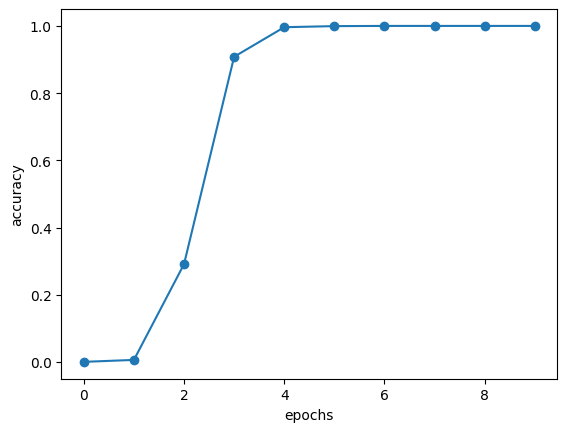

In [4]:
acc_peeky = train_peekySeq2seq()


===== Seq2seq Epoch 1/10 =====
| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 2[s] | loss 3.34
| epoch 1 |  iter 41 / 351 | time 5[s] | loss 1.95
| epoch 1 |  iter 61 / 351 | time 8[s] | loss 1.78
| epoch 1 |  iter 81 / 351 | time 10[s] | loss 1.70
| epoch 1 |  iter 101 / 351 | time 13[s] | loss 1.55
| epoch 1 |  iter 121 / 351 | time 16[s] | loss 1.27
| epoch 1 |  iter 141 / 351 | time 18[s] | loss 1.16
| epoch 1 |  iter 161 / 351 | time 21[s] | loss 1.12
| epoch 1 |  iter 181 / 351 | time 24[s] | loss 1.08
| epoch 1 |  iter 201 / 351 | time 26[s] | loss 1.06
| epoch 1 |  iter 221 / 351 | time 29[s] | loss 1.05
| epoch 1 |  iter 241 / 351 | time 32[s] | loss 1.04
| epoch 1 |  iter 261 / 351 | time 34[s] | loss 1.04
| epoch 1 |  iter 281 / 351 | time 37[s] | loss 1.03
| epoch 1 |  iter 301 / 351 | time 40[s] | loss 1.03
| epoch 1 |  iter 321 / 351 | time 42[s] | loss 1.03
| epoch 1 |  iter 341 / 351 | time 45[s] | loss 1.02
Q 10/15/94              

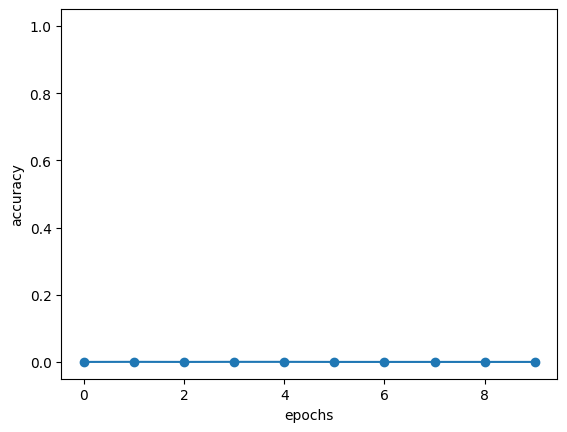

In [5]:
acc_seq2seq = train_Seq2seq()


===== AttentionSeq2seq Epoch 1/10 =====
| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 4[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 8[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 13[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 18[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 23[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 27[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 32[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 37[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 42[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 46[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 51[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 56[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 61[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 65[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 70[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 74[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 78[s] | loss 1.00
Q 10/15/94    

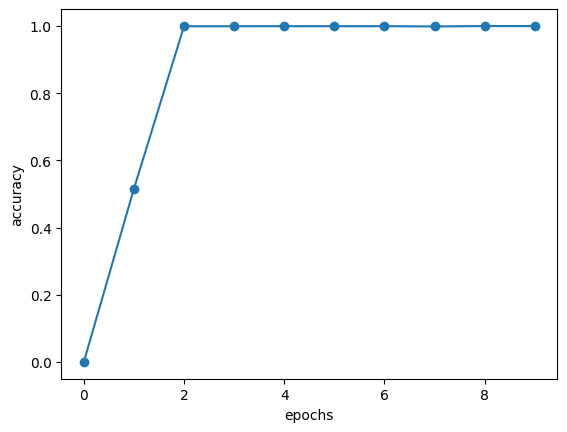

In [6]:
acc_attention = train_AttentionSeq2seq()

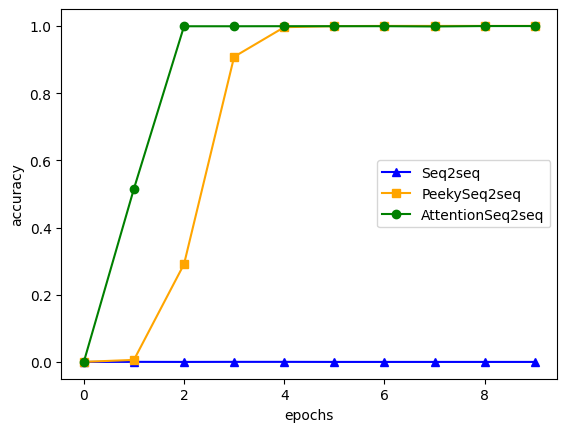

In [7]:
# ３つのモデルの精度を一つのグラフにプロット
epochs = np.arange(len(acc_seq2seq))
plt.plot(epochs, acc_seq2seq, marker='^', color='blue', label='Seq2seq')
plt.plot(epochs, acc_peeky, marker='s', color='orange', label='PeekySeq2seq')
plt.plot(epochs, acc_attention, marker='o', color='green', label='AttentionSeq2seq')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()